## Lasso regression for sparse data

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import class_FM as FM
from sklearn import preprocessing
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans


### Initialize factorial model and sample dataset for k=3

In [86]:
n = 10000
k = 3
degree = 3
sigma = 0.3
sparsity = 0.5

fm = FM.FactorialModel(
    n=n,
    k=k,
    degree=degree,
    sigma=sigma,
    sparsity=sparsity,
    beta_seed=41,
)
t, y = fm.sample(seed=0)


### Cross Validation Search for Alpha


In [95]:
pf = preprocessing.PolynomialFeatures(
    degree=degree, interaction_only=True, include_bias=True,
)
T = pf.fit_transform(t)
T_train, T_test, y_train, y_test = train_test_split(T, y, test_size=0.3, random_state=42)
alpha_cv = [0.001,0.01,0.1, 0.5]
model = LassoCV(alphas = alpha_cv, cv=5, random_state=42)
model.fit(T_train, y_train)
alpha = model.alpha_


0.001
[ 0.          0.24593838  0.          0.         -0.          1.0920634
  0.06200721 -1.1047195 ]
[ 0.          0.26711896  0.          0.          0.          1.1077682
  0.09375488 -1.1708181 ]


### Fit Lasso regression with sample data

In [96]:

model = Lasso(alpha=0.01)
model.fit(T_train, y_train)
print(model.coef_)

[ 0.          0.21244785 -0.          0.         -0.          0.95178205
 -0.         -0.83001375]


### Compute expected outcomes as linear combinations of betas

In [125]:
betas = model.coef_
print(betas)
beta_mask = pf.transform(pf.powers_)
print(beta_mask)
expected_outcomes = beta_mask @ betas
print(expected_outcomes)

[ 0.          0.21244785 -0.          0.         -0.          0.95178205
 -0.         -0.83001375]
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 1. 0. 1. 0. 0.]
 [1. 0. 1. 1. 0. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]
[0.         0.21244785 0.         0.         0.21244785 1.1642299
 0.         0.33421615]


### Plot betas and expected outcomes

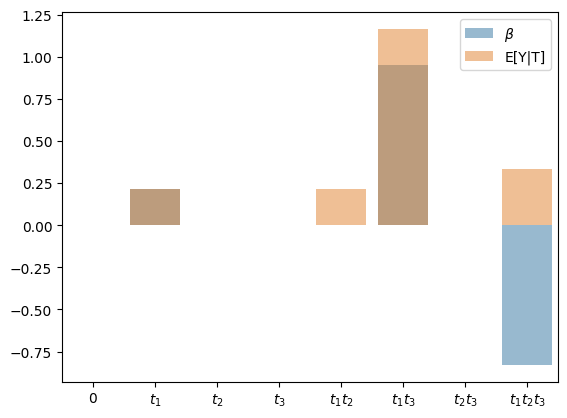

In [126]:
_ = sns.barplot(
    x=[
        r"0",
        r"$t_1$",
        r"$t_2$",
        r"$t_3$",
        r"$t_1 t_2$",
        r"$t_1 t_3$",
        r"$t_2 t_3$",
        r"$t_1 t_2 t_3$",
    ],
    y=betas,
    alpha=0.5,
    label=r"$\beta$",
)

_ = sns.barplot(
    x=[
        r"0",
        r"$t_1$",
        r"$t_2$",
        r"$t_3$",
        r"$t_1 t_2$",
        r"$t_1 t_3$",
        r"$t_2 t_3$",
        r"$t_1 t_2 t_3$",
    ],
    y=expected_outcomes,
    alpha=0.5,
    label=r"E[Y|T]",
)

### Cluster with KMeans Algorithm


In [179]:
# print(expected_outcomes)
def cross_val_kmeans(T_train: np.array, T_test: np.array, y_train: np.array,y_test: np.array, expected_outcomes: np.array,beta_mask:np.array,  max_clust:int):
    k_means_mse = {}
    # print(expected_outcomes)
    cluster_dict = {}
    
    for i in range(1,max_clust+1):
        kmeans = KMeans(n_clusters=i, random_state=0, n_init="auto").fit(expected_outcomes.reshape(-1,1))
        clusters_train = kmeans.predict(y_train.reshape(-1,1))
        # clusters_test = kmeans.predict(y_test.reshape(-1,1))
        for row in range(beta_mask.shape[0]):
            #convert binary combination to decimal to make a dictionary and map each combo to a group
            cluster_dict[beta_mask[row].dot(2**np.arange(beta_mask[row].size)[::-1])] = kmeans.labels_[row]
        mse = 0
        
        #decimalize all combinations
        powers_of_two = 2**np.arange(beta_mask.shape[1])[::-1]
        dec_test = T_test.dot(powers_of_two)
        combo_dict = { key: 0 for key in range(i)}
        eo_train = {}
        for k in range(i):
            eo_train[k] = np.mean(y_train[clusters_train==k])
        for key,value in cluster_dict.items():
            combo_dict[value] += np.sum((y_test[dec_test==key] - eo_train[value])**2)
        print(i, sum(combo_dict.values()))
        print(kmeans.labels_)
cross_val_kmeans(T_train, T_test,y_train, y_test,expected_outcomes, beta_mask,5)

1 226.62528202932663
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2 69.98290663726938
[0 0 1 1 0 0 0 0 1 1 1 1 0 0 1 0]
3 44.821749973392706
[0 0 1 1 0 0 0 0 2 1 1 1 0 0 2 0]
4 12.365039650272358
[3 0 1 1 3 3 3 0 2 1 1 1 0 3 2 3]
5 9.027676808735215
[3 4 1 1 3 3 3 4 2 1 1 1 0 3 2 3]


### Factorial model and sample dataset for k=4

In [173]:
n = 1000
k = 4
degree = 4
sigma = 0.1
sparsity = 0.5

fm = FM.FactorialModel(
    n=n,
    k=k,
    degree=degree,
    sigma=sigma,
    sparsity=sparsity,
    beta_seed=42,
)
t, y = fm.sample(seed=0)

In [174]:
# Fit Lasso regression
pf = preprocessing.PolynomialFeatures(
    degree=degree, interaction_only=True, include_bias=True,
)
T = pf.fit_transform(t)
T_train, T_test, y_train, y_test = train_test_split(T, y, test_size=0.3, random_state=42)
alpha_cv = [0.001,0.01,0.1, 0.5]
model = LassoCV(alphas = alpha_cv, cv=5, random_state=42)
model.fit(T_train, y_train)
alpha = model.alpha_

model = Lasso(alpha=alpha)
model.fit(T_train, y_train)
print(model.coef_)
print(fm.beta)

[ 0.         -1.0383812   0.74151677  0.92653066  0.         -0.01760102
  0.12800655 -0.30126548  0.          0.01136997  0.00642461 -0.
 -0.02599995 -0.          0.42120025 -0.8189125 ]
[ 0.         -1.0399841   0.7504512   0.9405647   0.          0.
  0.1278404  -0.3162426  -0.01680116  0.          0.          0.
  0.          0.          0.46750933 -0.85929245]


In [177]:
# Compute expected outcomes
betas = model.coef_
beta_mask = pf.fit_transform(pf.powers_)
expected_outcomes = beta_mask @ betas
print(expected_outcomes)

[ 0.         -1.03838122  0.74151677  0.92653066  0.         -0.31446547
  0.01615599 -1.3396467   1.66804743  0.75288674  0.93295527  0.74007173
 -0.63036092 -0.27868488  2.10704226  0.03288864]


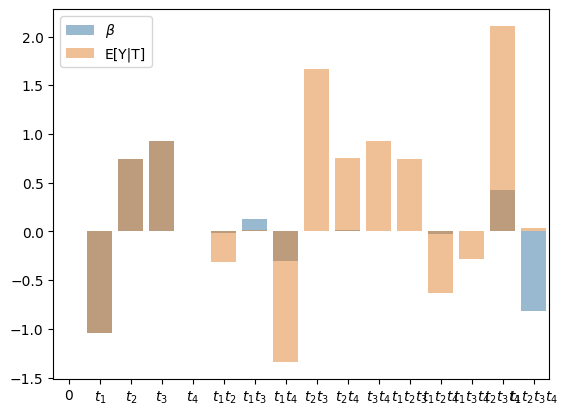

In [168]:
# Plot betas and expected outcomes
_ = sns.barplot(
    x=[
        r"0",
        r"$t_1$",
        r"$t_2$",
        r"$t_3$",
        r"$t_4$",
        r"$t_1 t_2$",
        r"$t_1 t_3$",
        r"$t_1 t_4$",
        r"$t_2 t_3$",
        r"$t_2 t_4$",
        r"$t_3 t_4$",
        r"$t_1 t_2 t_3$",
        r"$t_1 t_2 t_4$",
        r"$t_1 t_3 t_4$",
        r"$t_2 t_3 t_4$",
        r"$t_1 t_2 t_3 t_4$",
    ],
    y=betas,
    alpha=0.5,
    label=r"$\beta$",
)

_ = sns.barplot(
    x=[
        r"0",
        r"$t_1$",
        r"$t_2$",
        r"$t_3$",
        r"$t_4$",
        r"$t_1 t_2$",
        r"$t_1 t_3$",
        r"$t_1 t_4$",
        r"$t_2 t_3$",
        r"$t_2 t_4$",
        r"$t_3 t_4$",
        r"$t_1 t_2 t_3$",
        r"$t_1 t_2 t_4$",
        r"$t_1 t_3 t_4$",
        r"$t_2 t_3 t_4$",
        r"$t_1 t_2 t_3 t_4$",
    ],
    y=expected_outcomes,
    alpha=0.5,
    label=r"E[Y|T]",
)

### Find Kmeans clusters

In [180]:

cross_val_kmeans(T_train, T_test,y_train, y_test,expected_outcomes, beta_mask,15)

1 226.62528202932663
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2 69.98290663726938
[0 0 1 1 0 0 0 0 1 1 1 1 0 0 1 0]
3 44.821749973392706
[0 0 1 1 0 0 0 0 2 1 1 1 0 0 2 0]
4 12.365039650272358
[3 0 1 1 3 3 3 0 2 1 1 1 0 3 2 3]
5 9.027676808735215
[3 4 1 1 3 3 3 4 2 1 1 1 0 3 2 3]
6 5.835281616594306
[3 4 1 1 3 5 3 4 2 1 1 1 0 5 2 3]
7 4.2762259123037465
[3 4 1 1 3 5 3 4 6 1 1 1 0 5 2 3]
8 3.812945890371637
[3 4 7 1 3 5 3 4 6 7 1 7 0 5 2 3]
9 2.992498840140452
[3 8 7 1 3 5 3 4 6 7 1 7 0 5 2 3]
10 3.274679079121633
[3 8 7 1 3 5 3 4 6 7 1 7 0 9 2 3]
11 3.7334673657358626
[ 3  8  7  1  3  5  3  4  6  7  1  7  0  9  2 10]
12 3.5756259096737377
[ 3  8  7  1  3  5 11  4  6  7  1  7  0  9  2 10]
13 3.8919978150417993
[ 3  8  7  1  3  5 11  4  6 12  1  7  0  9  2 10]
14 4.00887981730433
[ 3  8  7 13  3  5 11  4  6 12  1  7  0  9  2 10]
15 3.8731012787620718
[ 3  8  7 13  3  5 11  4  6 12  1 14  0  9  2 10]


### Factorial model and sample dataset for k=5

In [57]:
n = 1000
k = 5
degree = 5
sigma = 0.1
sparsity = 0.5

fm = FM.FactorialModel(
    n=n,
    k=k,
    degree=degree,
    sigma=sigma,
    sparsity=sparsity,
    beta_seed=42,
)
t, y = fm.sample(seed=0)

In [58]:
# Fit Lasso regression
pf = preprocessing.PolynomialFeatures(
    degree=degree, interaction_only=True, include_bias=True,
)
T = pf.fit_transform(t)
model = Lasso(alpha=0.1)
model.fit(T, y)
print(model.coef_)

[ 0.          0.          0.45883626  0.         -0.         -0.
  0.          0.         -0.         -0.          0.41779137  0.
  0.          0.          0.         -0.33889037  0.          0.
  0.          0.          0.         -0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.
  0.          0.        ]


In [59]:
# Compute expected outcomes
betas = model.coef_
beta_mask = pf.fit_transform(pf.powers_)
expected_outcomes = beta_mask @ betas
print(expected_outcomes)

[ 0.          0.          0.45883626  0.          0.          0.
  0.45883626  0.          0.          0.          0.87662762  0.45883626
  0.45883626  0.          0.         -0.33889037  0.87662762  0.45883626
  0.45883626  0.          0.         -0.33889037  0.87662762  0.87662762
  0.11994588 -0.33889037  0.87662762  0.87662762  0.11994588 -0.33889037
  0.53773725  0.53773725]


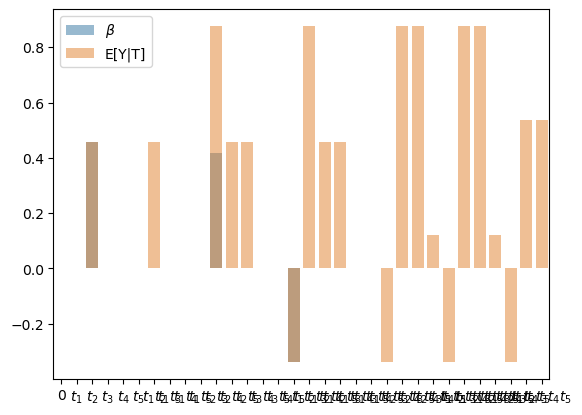

In [60]:
# Plot betas and expected outcomes
_ = sns.barplot(
    x=[
        r"0",
        r"$t_1$",
        r"$t_2$",
        r"$t_3$",
        r"$t_4$",
        r"$t_5$",
        r"$t_1 t_2$",
        r"$t_1 t_3$",
        r"$t_1 t_4$",
        r"$t_1 t_5$",
        r"$t_2 t_3$",
        r"$t_2 t_4$",
        r"$t_2 t_5$",
        r"$t_3 t_4$",
        r"$t_3 t_5$",
        r"$t_4 t_5$",
        r"$t_1 t_2 t_3$",
        r"$t_1 t_2 t_4$",
        r"$t_1 t_2 t_5$",
        r"$t_1 t_3 t_4$",
        r"$t_1 t_3 t_5$",
        r"$t_1 t_4 t_5$",
        r"$t_2 t_3 t_4$",
        r"$t_2 t_3 t_5$",
        r"$t_2 t_4 t_5$",
        r"$t_3 t_4 t_5$",
        r"$t_1 t_2 t_3 t_4$",
        r"$t_1 t_2 t_3 t_5$",
        r"$t_1 t_2 t_4 t_5$",
        r"$t_1 t_3 t_4 t_5$",
        r"$t_2 t_3 t_4 t_5$",
        r"$t_1 t_2 t_3 t_4 t_5$",
    ],
    y=betas,
    alpha=0.5,
    label=r"$\beta$",
)

_ = sns.barplot(
    x=[
        r"0",
        r"$t_1$",
        r"$t_2$",
        r"$t_3$",
        r"$t_4$",
        r"$t_5$",
        r"$t_1 t_2$",
        r"$t_1 t_3$",
        r"$t_1 t_4$",
        r"$t_1 t_5$",
        r"$t_2 t_3$",
        r"$t_2 t_4$",
        r"$t_2 t_5$",
        r"$t_3 t_4$",
        r"$t_3 t_5$",
        r"$t_4 t_5$",
        r"$t_1 t_2 t_3$",
        r"$t_1 t_2 t_4$",
        r"$t_1 t_2 t_5$",
        r"$t_1 t_3 t_4$",
        r"$t_1 t_3 t_5$",
        r"$t_1 t_4 t_5$",
        r"$t_2 t_3 t_4$",
        r"$t_2 t_3 t_5$",
        r"$t_2 t_4 t_5$",
        r"$t_3 t_4 t_5$",
        r"$t_1 t_2 t_3 t_4$",
        r"$t_1 t_2 t_3 t_5$",
        r"$t_1 t_2 t_4 t_5$",
        r"$t_1 t_3 t_4 t_5$",
        r"$t_2 t_3 t_4 t_5$",
        r"$t_1 t_2 t_3 t_4 t_5$",
    ],
    y=expected_outcomes,
    alpha=0.5,
    label=r"E[Y|T]",
)